In [1]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
import umap

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs

/home/david/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-11-29_09-14-00/


In [4]:
# Convert MNIST data to numpy arrays
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    train_images.append(input.cpu().numpy())
    train_labels.append(target.cpu().numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    test_images.append(input.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

### Load models

In [5]:
modelpath = '/home/david/sparsify_models/good_models/01/'

sae_model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
dae_model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)

sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
sae_model.load_state_dict(sae_weights)

dae_weights = torch.load(modelpath + 'DAE/model_weights_epoch49.pth')
dae_model.load_state_dict(dae_weights)

/tmp/ipykernel_12761/1097132316.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
/tmp/ipykernel_1276

<All keys matched successfully>

### Retrieve encodings

In [6]:
sae_train_encodings = []

with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_train_encodings.append(encoded.cpu().detach().numpy())

sae_train_encodings = np.concatenate(sae_train_encodings)


sae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings.append(encoded.cpu().detach().numpy())

sae_test_encodings = np.concatenate(sae_test_encodings)

In [7]:
dae_train_encodings = []

with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_train_encodings.append(encoded.cpu().detach().numpy())

dae_train_encodings = np.concatenate(dae_train_encodings)


dae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_test_encodings.append(encoded.cpu().detach().numpy())

dae_test_encodings = np.concatenate(dae_test_encodings)

### Classification accuracy of SAE and DAE encodings with a Linear SVC

In [8]:
sae_svc = LinearSVC(max_iter=1000, C=1.0)
sae_svc.fit(sae_train_encodings, train_labels)

sae_predictions = sae_svc.predict(sae_test_encodings)
accuracy = accuracy_score(test_labels, sae_predictions)
print(f'SVC trained on SAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Accuracy: 0.8868


In [9]:
dae_svc = LinearSVC(max_iter=1000, C=1.0)
dae_svc.fit(dae_train_encodings, train_labels)

dae_predictions = dae_svc.predict(dae_test_encodings)
accuracy = accuracy_score(test_labels, dae_predictions)
print(f'SVC trained on DAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on DAE encodings - Accuracy: 0.8871


### Adding noise

In [10]:
def add_gaussian_noise(raw_data, var=0.01):
    noisy_data = []
    for original in raw_data:
        noisy = random_noise(original, mode='gaussian', var=var)
        noisy_data.append(noisy)
    
    return noisy_data


noisy_test_images = add_gaussian_noise(test_images, 0.1)

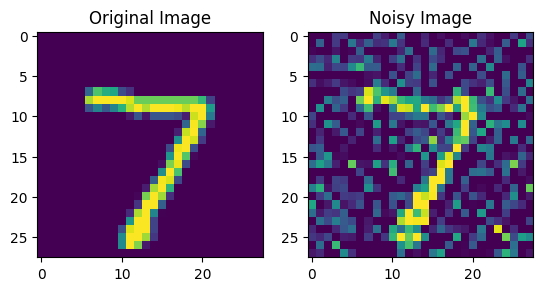

In [11]:
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(test_images[0].reshape(28, 28))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_test_images[0].reshape(28, 28))
plt.title('Noisy Image')

plt.show()

### Adding noise to the encodings

In [25]:
sae_train_noisy_encodings = []
sae_test_noisy_encodings = []
dae_train_noisy_encodings = []
dae_test_noisy_encodings = []

for image in sae_train_encodings:
    sae_train_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in sae_test_encodings:
    sae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in dae_train_encodings:
    dae_train_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in dae_test_encodings:
    dae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

In [32]:
noisy_encoding_predictions = sae_svc.predict(sae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, noisy_encoding_predictions)
print(f'SVC trained on SAE encodings - Noisy - Accuracy: {accuracy:.4f}')

noisy_encoding_predictions = dae_svc.predict(dae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, noisy_encoding_predictions)
print(f'SVC trained on DAE encodings - Noisy - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Noisy - Accuracy: 0.5486
SVC trained on DAE encodings - Noisy - Accuracy: 0.1969


In [39]:
#SVC trained on noisy encodings
noisy_encoding_sae_svc = LinearSVC(max_iter=1000, C=1.0)
noisy_encoding_sae_svc.fit(sae_train_noisy_encodings, train_labels)
predictions = noisy_encoding_sae_svc.predict(sae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, predictions)
print(f'SVC trained on SAE encodings - Noisy - Accuracy: {accuracy:.4f}')

noisy_encoding_dae_svc = LinearSVC(max_iter=1000, C=1.0)
noisy_encoding_dae_svc.fit(dae_train_noisy_encodings, train_labels)
predictions = noisy_encoding_dae_svc.predict(dae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, predictions)
print(f'SVC trained on DAE encodings - Noisy - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Noisy - Accuracy: 0.6222
SVC trained on DAE encodings - Noisy - Accuracy: 0.3752


### Adding noise to the images

In [31]:
noisy_train_images = add_gaussian_noise(train_images, 0.5)
noisy_test_images = add_gaussian_noise(test_images, 0.5)

sae_train_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_train_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

sae_train_encodings_from_noisy_images = np.concatenate(sae_train_encodings_from_noisy_images)


sae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

sae_test_encodings_from_noisy_images = np.concatenate(sae_test_encodings_from_noisy_images)

In [ ]:
dae_train_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_train_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

dae_train_encodings_from_noisy_images = np.concatenate(dae_train_encodings_from_noisy_images)


dae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

dae_test_encodings_from_noisy_images = np.concatenate(dae_test_encodings_from_noisy_images)

### Classification accuracy of noisy SAE and DAE encodings with a Linear SVC

In [ ]:
sae_noisy_predictions = sae_svc.predict(sae_test_encodings_from_noisy_images)
accuracy = accuracy_score(sae_noisy_predictions, test_labels)
print(f'SVC trained on SAE encodings - Accuracy on noisy encodings: {accuracy:.4f}')

dae_noisy_predictions = dae_svc.predict(dae_test_encodings_from_noisy_images)
accuracy = accuracy_score(dae_noisy_predictions, test_labels)
print(f'SVC trained on DAE encodings - Accuracy on noisy encodings: {accuracy:.4f}')

SVC trained on SAE encodings - Accuracy on noisy encodings: 0.4306
SVC trained on DAE encodings - Accuracy on noisy encodings: 0.4603


### Classification accuracy of noisy SAE and DAE encodings with a Linear SVC (trained on noisy data)

In [ ]:
sae_noisy_svc = LinearSVC(max_iter=1000, C=1.0)
sae_noisy_svc.fit(sae_train_encodings_from_noisy_images, train_labels)

sae_noisy_predictions = sae_noisy_svc.predict(sae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, sae_noisy_predictions)
print(f'SVC trained on noisy SAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on noisy SAE encodings - Accuracy: 0.7557


In [ ]:
dae_noisy_svc = LinearSVC(max_iter=1000, C=1.0)
dae_noisy_svc.fit(dae_train_encodings_from_noisy_images, train_labels)

dae_noisy_predictions = dae_noisy_svc.predict(dae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, dae_noisy_predictions)
print(f'SVC trained on noisy DAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on noisy DAE encodings - Accuracy: 0.7403


### Plotting results

In [ ]:
data = []

for var in [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9]:
    gaussian_noise_images = add_gaussian_noise(test_images, var)

    for noise_type, noisy_test_images in [("gaussian", gaussian_noise_images)]:        
        sae_test_encodings_from_noisy_images = []
        dae_test_encodings_from_noisy_images = []

        for image in noisy_test_images:
            image = torch.tensor(image).float().to('cuda')
            input = image.view(1, -1).to('cpu')
            encoded, decoded = sae_model(input)
            sae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())
            encoded, decoded = dae_model(input.to('cpu'))
            dae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

        sae_test_encodings_from_noisy_images = np.concatenate(sae_test_encodings_from_noisy_images, axis=0)
        dae_test_encodings_from_noisy_images = np.concatenate(dae_test_encodings_from_noisy_images, axis=0)

        sae_noisy_predictions = sae_svc.predict(sae_test_encodings_from_noisy_images)
        dae_noisy_predictions = dae_svc.predict(dae_test_encodings_from_noisy_images)
        sae_noisy_svc_predictions = sae_noisy_svc.predict(sae_test_encodings_from_noisy_images)
        dae_noisy_svc_predictions = dae_noisy_svc.predict(dae_test_encodings_from_noisy_images)
        
        sae_noisy_accuracy = accuracy_score(sae_noisy_predictions, test_labels)
        dae_noisy_accuracy = accuracy_score(dae_noisy_predictions, test_labels)
        sae_noisy_svc_accuracy = accuracy_score(sae_noisy_svc_predictions, test_labels)
        dae_noisy_svc_accuracy = accuracy_score(dae_noisy_svc_predictions, test_labels)

        data.append({'variance': var, 
                     'noise': noise_type, 
                     'sae_noisy_accuracy': sae_noisy_accuracy, 
                     'dae_noisy_accuracy': dae_noisy_accuracy, 
                     'sae_noisy_svc_accuracy': sae_noisy_svc_accuracy, 
                     'dae_noisy_svc_accuracy': dae_noisy_svc_accuracy
                     })

In [51]:
data = []

for var in [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9]:
    gaussian_noise_images = add_gaussian_noise(test_images, var)

    sae_test_noisy_encodings = []
    dae_test_noisy_encodings = []

    for image in sae_test_encodings:
        sae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=var))

    for image in dae_test_encodings:
        dae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=var))
    
    sae_test_encodings_from_noisy_images = []
    dae_test_encodings_from_noisy_images = []

    for i in range(10000):
        image = torch.tensor(gaussian_noise_images[i]).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())
        encoded, decoded = dae_model(input.to('cpu'))
        dae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

    sae_test_encodings_from_noisy_images = np.concatenate(sae_test_encodings_from_noisy_images, axis=0)
    dae_test_encodings_from_noisy_images = np.concatenate(dae_test_encodings_from_noisy_images, axis=0)

    sae_noisy_predictions = sae_svc.predict(sae_test_encodings_from_noisy_images)
    dae_noisy_predictions = dae_svc.predict(dae_test_encodings_from_noisy_images)
    sae_noisy_svc_predictions = sae_noisy_svc.predict(sae_test_encodings_from_noisy_images)
    dae_noisy_svc_predictions = dae_noisy_svc.predict(dae_test_encodings_from_noisy_images)
    
    sae_noisy_accuracy = accuracy_score(sae_noisy_predictions, test_labels)
    dae_noisy_accuracy = accuracy_score(dae_noisy_predictions, test_labels)
    sae_noisy_svc_accuracy = accuracy_score(sae_noisy_svc_predictions, test_labels)
    dae_noisy_svc_accuracy = accuracy_score(dae_noisy_svc_predictions, test_labels)

    noisy_encoding_predictions = sae_svc.predict(sae_test_noisy_encodings)
    sae_noisy_encoding_accuracy = accuracy_score(test_labels, noisy_encoding_predictions)

    noisy_encoding_predictions = dae_svc.predict(dae_test_noisy_encodings)
    dae_noisy_encoding_accuracy = accuracy_score(test_labels, noisy_encoding_predictions)

    predictions = noisy_encoding_sae_svc.predict(sae_test_noisy_encodings)
    sae_noisy_encoding_svc_accuracy = accuracy_score(test_labels, predictions)

    predictions = noisy_encoding_dae_svc.predict(dae_test_noisy_encodings)
    dae_noisy_encoding_svc_accuracy = accuracy_score(test_labels, predictions)

    data.append({'variance': var, 
                    'sae_noisy_accuracy': sae_noisy_accuracy, 
                    'dae_noisy_accuracy': dae_noisy_accuracy, 
                    'sae_noisy_svc_accuracy': sae_noisy_svc_accuracy, 
                    'dae_noisy_svc_accuracy': dae_noisy_svc_accuracy,
                    'sae_noisy_encoding_accuracy': sae_noisy_encoding_accuracy,
                    'dae_noisy_encoding_accuracy': sae_noisy_encoding_accuracy,
                    'sae_noisy_encoding_svc_accuracy': sae_noisy_encoding_svc_accuracy,
                    'sae_noisy_encoding_svc_accuracy': sae_noisy_encoding_svc_accuracy
                    })

In [ ]:
plt.figure()
plt.plot([d['variance'] for d in data, d['sae_noisy_accuracy'] for d in data], label='SAE')
plt.plot([d['variance'] for d in data if d['noise'] == 'gaussian'], [d['dae_noisy_accuracy'] for d in data if d['noise'] == 'gaussian'], label='DAE')
plt.plot([d['variance'] for d in data if d['noise'] == 'gaussian'], [d['sae_noisy_svc_accuracy'] for d in data if d['noise'] == 'gaussian'], label='SAE (trained on noisy data)')
plt.plot([d['variance'] for d in data if d['noise'] == 'gaussian'], [d['dae_noisy_svc_accuracy'] for d in data if d['noise'] == 'gaussian'], label='DAE (trained on noisy data)')
plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.title('Gaussian Noise')
plt.legend()
plt.show()


SyntaxError: invalid syntax (4124678920.py, line 2)

In [19]:
noisy_train_images = add_gaussian_noise(train_images, 0.1)
noisy_test_images = add_gaussian_noise(test_images, 0.1)



# Options to evaluate
- Noisy images -> encode -> classify
    - SVC trained on original images (data too large)
    - SVC trained on noisy images (data too large)
- Noisy encodings -> classify
    - SVC trained on original encodings (SAE = 0.82, DAE = 0.39)
    - SVC trained on noisy encodings (SAE = 0.06, DAE = 0.11)

In [ ]:
noisy_train_images = add_gaussian_noise(train_images, 0.1)
noisy_test_images = add_gaussian_noise(test_images, 0.1)


sae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

sae_test_encodings_from_noisy_images = np.concatenate(sae_test_encodings_from_noisy_images)


dae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

dae_test_encodings_from_noisy_images = np.concatenate(dae_test_encodings_from_noisy_images)

In [ ]:
reducer = umap.UMAP(n_components=2)
sae_umap = reducer.fit_transform(sae_test_encodings)

reducer = umap.UMAP(n_components=2)
dae_umap = reducer.fit_transform(dae_test_encodings)

reducer = umap.UMAP(n_components=2)
noisy_sae_umap = reducer.fit_transform(sae_test_encodings_from_noisy_images)

reducer = umap.UMAP(n_components=2)
noisy_dae_umap = reducer.fit_transform(dae_test_encodings_from_noisy_images)

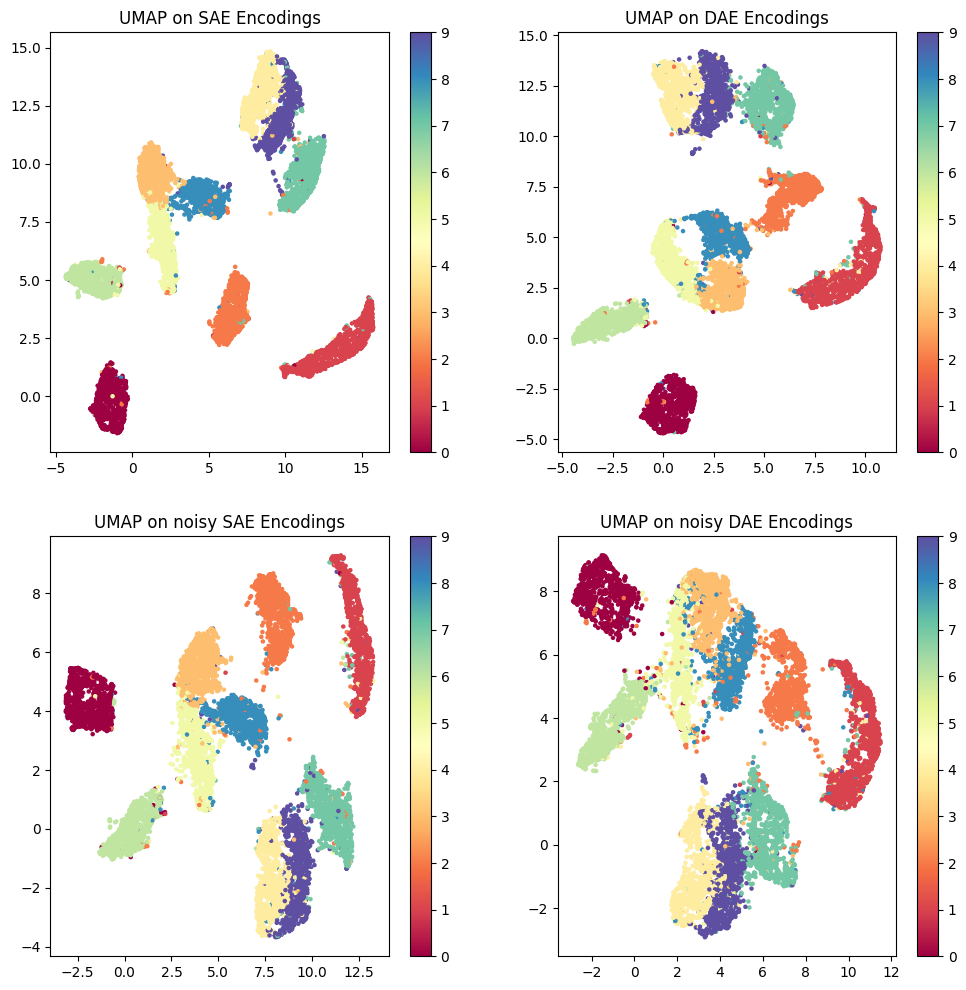

In [22]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
scatter = plt.scatter(sae_umap[:, 0], sae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on SAE Encodings")

plt.subplot(2, 2, 2)
scatter = plt.scatter(dae_umap[:, 0], dae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on DAE Encodings")

plt.subplot(2, 2, 3)
scatter = plt.scatter(noisy_sae_umap[:, 0], noisy_sae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on noisy SAE Encodings")

plt.subplot(2, 2, 4)
scatter = plt.scatter(noisy_dae_umap[:, 0], noisy_dae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on noisy DAE Encodings")

plt.show()